## EDA
### 라이브러리

In [25]:
import os
import json
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

### 경로

In [23]:
image_dir = "../data/train/DCM"
json_dir = "../data/train/outputs_json" 

### Class 분포
#### - Class별 개수

Text(0, 0.5, 'Count')

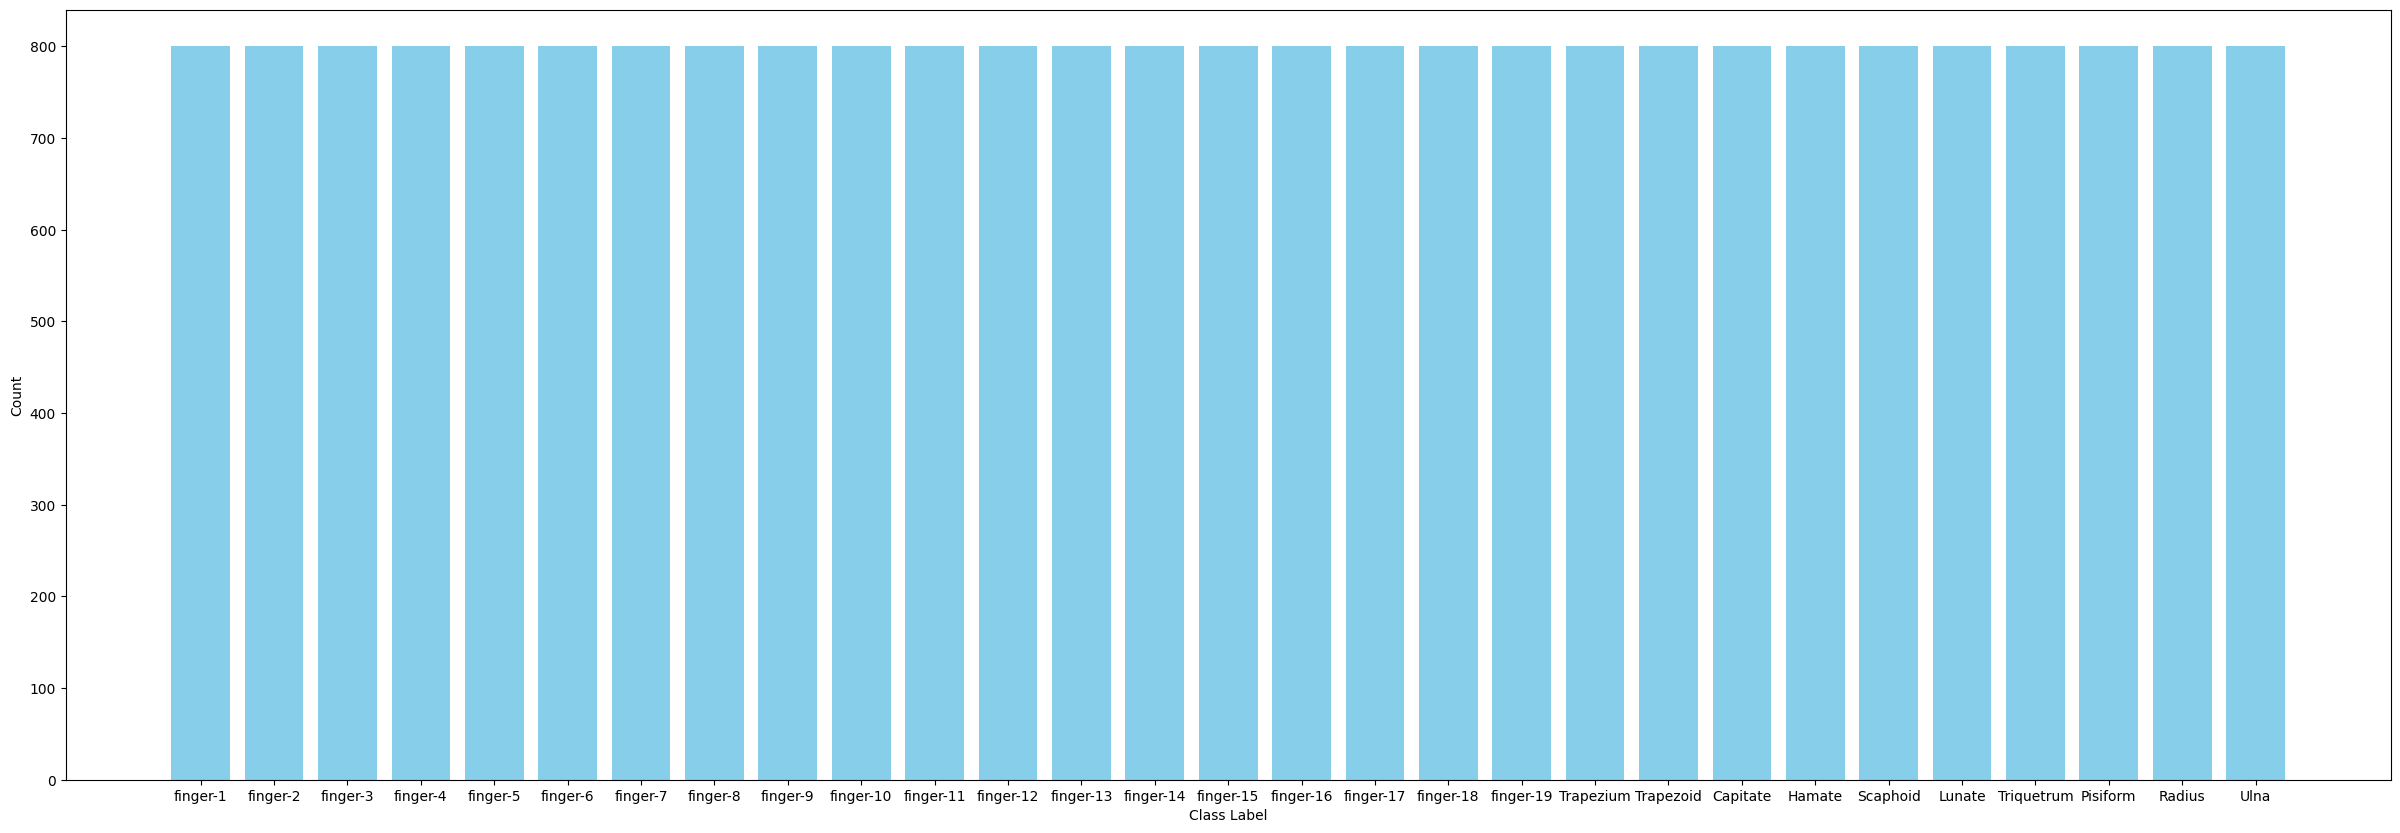

In [24]:
label_counts = Counter()

for json_file in glob(os.path.join(json_dir, "**", "*.json"), recursive=True):
    with open(json_file, "r", encoding="utf-8") as file:
        data = json.load(file)
        label_counts.update(annotation['label'] for annotation in data['annotations'])

plt.figure(figsize=(30, 10))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Count")


#### - Class별 pixel 차지 비율

#### - 이미지 당 29개의 클래스 유무 확인

### Metadata 분포
#### - 나이, 성별, 몸무게, 키 분포

/var/folders/rg/4_8hlqjs5kg9dvphjv_lnl3m0000gn/T/ipykernel_3178/1041431946.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=meta_data, palette="Set2")
/var/folders/rg/4_8hlqjs5kg9dvphjv_lnl3m0000gn/T/ipykernel_3178/1041431946.py:36: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  plt.tight_layout()
/var/folders/rg/4_8hlqjs5kg9dvphjv_lnl3m0000gn/T/ipykernel_3178/1041431946.py:36: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/I

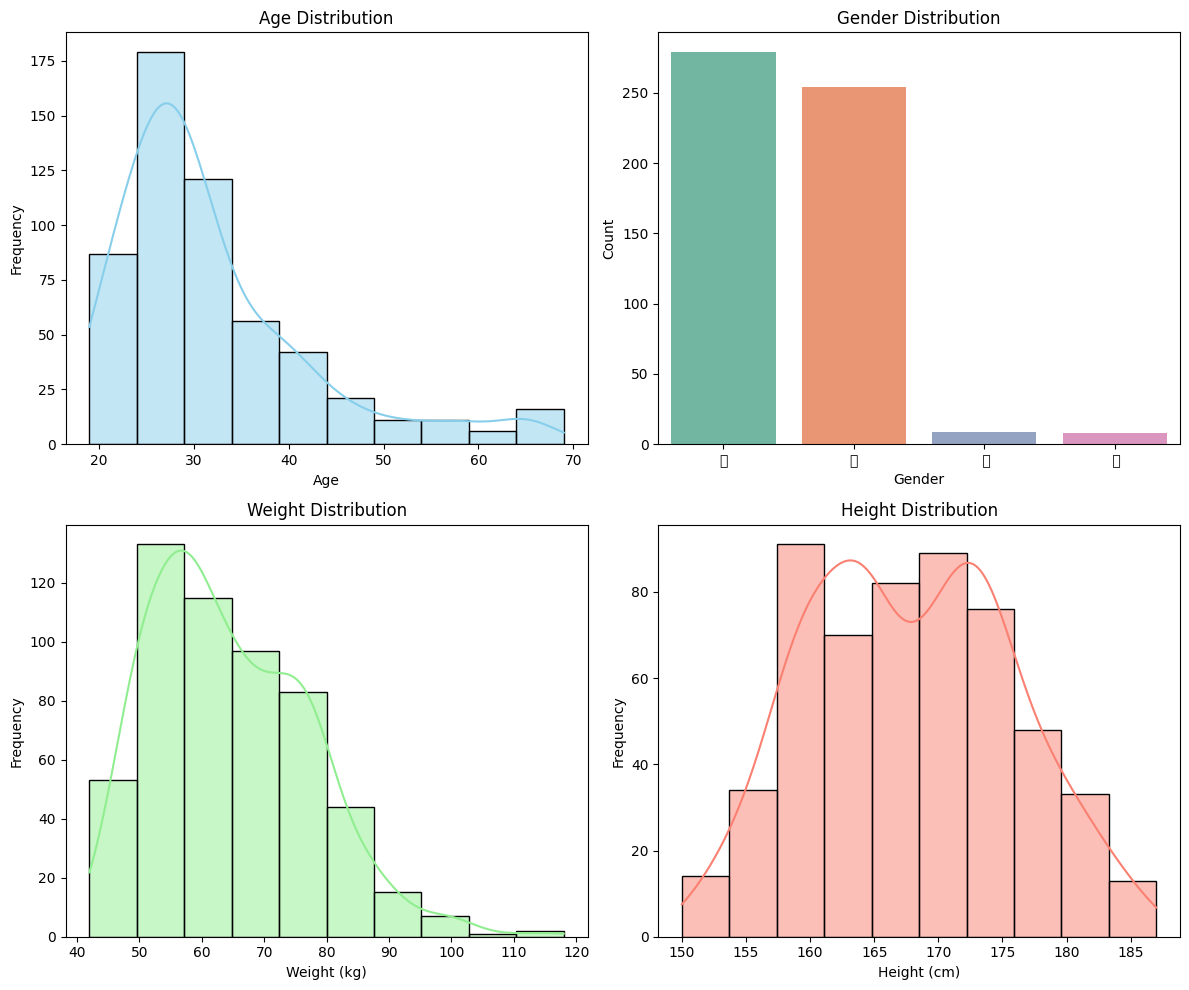

In [27]:
csv_path = "../data/meta_data.csv"
meta_data = pd.read_csv(csv_path)

meta_data.columns = ['Id', 'Age', 'Gender', 'Weight', 'Height', 'Extra']

plt.figure(figsize=(12, 10))

# 나이 분포
plt.subplot(2, 2, 1)
sns.histplot(meta_data['Age'], bins=10, kde=True, color="skyblue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")

# 성별 분포
plt.subplot(2, 2, 2)
sns.countplot(x='Gender', data=meta_data, palette="Set2")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")

# 몸무게 분포
plt.subplot(2, 2, 3)
sns.histplot(meta_data['Weight'], bins=10, kde=True, color="lightgreen")
plt.title("Weight Distribution")
plt.xlabel("Weight (kg)")
plt.ylabel("Frequency")

# 키 분포
plt.subplot(2, 2, 4)
sns.histplot(meta_data['Height'], bins=10, kde=True, color="salmon")
plt.title("Height Distribution")
plt.xlabel("Height (cm)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#### - 성별에 따른 나이, 몸무게, 키 분포

/var/folders/rg/4_8hlqjs5kg9dvphjv_lnl3m0000gn/T/ipykernel_3178/545829100.py:18: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  plt.tight_layout()
/var/folders/rg/4_8hlqjs5kg9dvphjv_lnl3m0000gn/T/ipykernel_3178/545829100.py:18: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


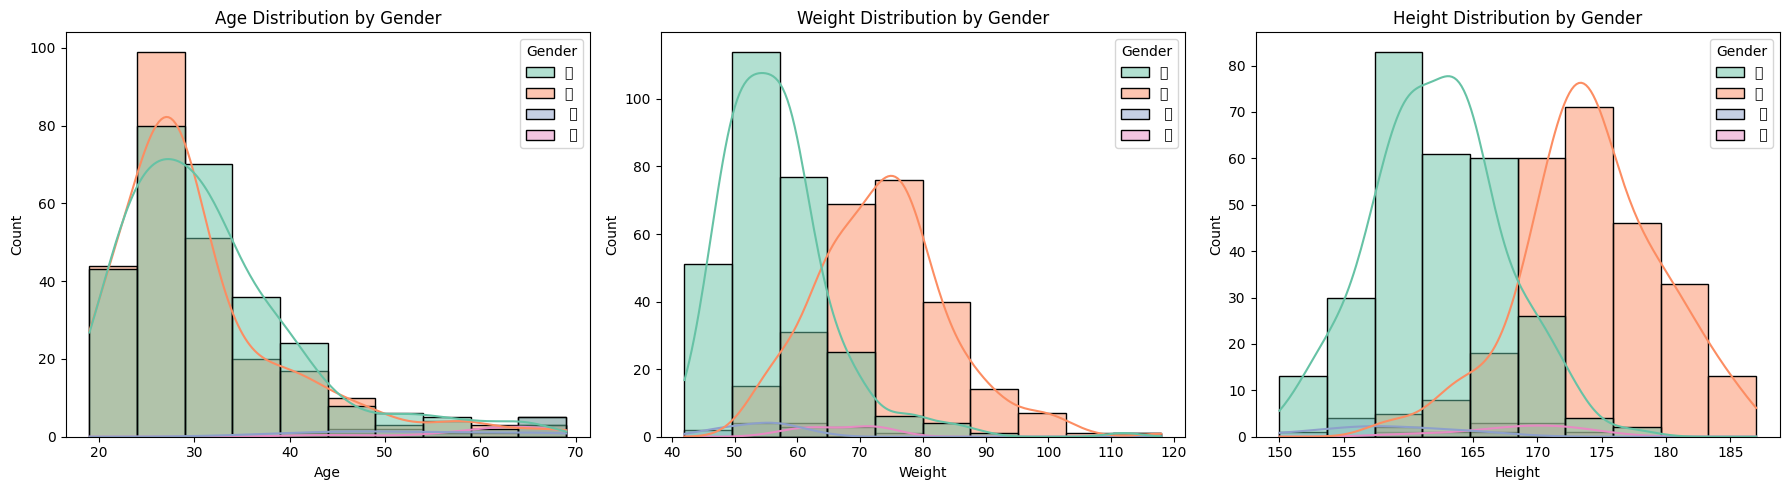

In [28]:
plt.figure(figsize=(18, 5))

# 성별에 따른 나이 분포
plt.subplot(1, 3, 1)
sns.histplot(data=meta_data, x="Age", hue="Gender", bins=10, kde=True, palette="Set2")
plt.title("Age Distribution by Gender")

# 성별에 따른 몸무게 분포
plt.subplot(1, 3, 2)
sns.histplot(data=meta_data, x="Weight", hue="Gender", bins=10, kde=True, palette="Set2")
plt.title("Weight Distribution by Gender")

# 성별에 따른 키 분포
plt.subplot(1, 3, 3)
sns.histplot(data=meta_data, x="Height", hue="Gender", bins=10, kde=True, palette="Set2")
plt.title("Height Distribution by Gender")

plt.tight_layout()
plt.show()

#### - 나이, 성별에 따른 뼈의 밀도 분포

#### - 키에 따른 뼈 면적 분포